# IRRmodel\*WCM calibration with PSO on KGE of $\sigma^0$

The v9 code (OR def) is a final, cleaned and commented version.
This version, wrt to v8, implements an hourly ET0 calculated with hourly FAO-56 Penman-Monteith and a SWB model that is properly corrected for hourly calculation of the evapotranspiration.
Kc curves are also externally defined in a module of their own.

# Dependencies

In [1]:
import sys
sys.path.append('../')

from modules.funcs import *
from modules.funcs_pso import *
from modules.funcs_plot import *
from modules.IRRI_WCM_model import *
from modules.Kc_curve import Kc_curve
from modules.EPOT_Hargreaves_pyeto import *

from scipy.signal import savgol_filter

# Data pre-processing

Input data formatting convention:
- ausiliary variables for extraction of data (directory name, file name, etc...)
- extraction into pd dataframe
- cleaning, resampling: drop unnecessary columns, set index to daily DateIndex

In [2]:
print('Starting...\n'
      +'#-------------------------------------------------------------\n'
      #+'Use of satellite-derived SM is provided for comparison, not calibration.\n'
     )
verbose = True if input("Verbose data extraction? (Describe datasets/files) [y/n]")=='y' else False

params = []; norma = ''

print('\n#-------------SWB model parameters-------------')
irri = False
year = 2017 # int(input('Do you want to calibrate on year 2017 or 2020? [2017/2020]'))
freq = 'h' # input('Daily or hourly frequency? [d/h]')

print('\n#-------------WCM model parameters-------------')
units = 'lin' # input('Calibrate WCM in linear or dB scale (determines scale of A)? [lin/db]')
opt_veg = 'NDVI'

print('\n#------------Optimization parameters-----------')
opt_calib = '1' # input('Cost function (KGE) on sigma0 (1) or sigma0 and soil moisture (2)? [1/2]')
opt_cost = 'KGE'

PAR_str_add = '_' + str(year) + input('Any addition to parameters\' names? [Type string to add]')
nrun = int(input('Number of runs? (10 is min to study distribution of parameters.) '))
n_particles = int(input('Number of particles: '))
n_step = int(input('Number of optimization steps: '))
optim = input('Global or Local PSO optimizer? [[global]/local] ')
if optim=='local': norma = 1 if input('Which norm? [l1/l2] ')=='l1' else 2
verbose_calib = True if input('Verbose during calibration? [y/n]')=='y' else False
automate = True if input('Run and save everything automatically? [y/n]')=='y' else False

Starting...
#-------------------------------------------------------------



Verbose data extraction? (Describe datasets/files) [y/n] n



#-------------SWB model parameters-------------

#-------------WCM model parameters-------------

#------------Optimization parameters-----------


Any addition to parameters' names? [Type string to add] _w-max-6GHz
Number of runs? (10 is min to study distribution of parameters.)  20
Number of particles:  20
Number of optimization steps:  200
Global or Local PSO optimizer? [[global]/local]  
Verbose during calibration? [y/n] n
Run and save everything automatically? [y/n] y


## IRRmodel

Frequency: daily

Inputs:
- rain (sum, end of day)
- et0 (daily)

Comparisons:
- irrigation (sum, end of day)
- soil moisture (mean, end of day)

In [3]:
#----------------------------------------------------------------------------
# Budrio field data from platinum_df tables

# Freq: H
# Data extracted:
# - SWC (as input SWB/comparison)
# - rain (as input SWB)
# - irrigation (as input SWB)
# - temperature (as input SWB, ET0 estimate)

platinum_df = pd.ExcelFile('..\Inputs\Platinum_Budrio.xlsx', engine='openpyxl')
if year==2017: sheet='2017_1h'
if year==2020: sheet='2020_1h'
platinum_df = platinum_df.parse(sheet)
# platinum_df = pd.concat([platinum_df.parse('2017_1h'), platinum_df.parse('2020_1h')])

# Column 'Date' contains date+hour = hourly information
# Column 'Data' contains only date = daily information
platinum_df['Ora_1'] = pd.to_datetime(platinum_df['Ora'].astype('str')).apply(lambda x: x.time())
platinum_df['Data_1'] = pd.to_datetime(platinum_df['Data'].astype('str')).apply(lambda x: x.date())
platinum_df['Datetime'] = platinum_df.apply(lambda r : dtt.datetime.combine(r['Data_1'],r['Ora_1']),1)
platinum_df = platinum_df.drop(['ID', 'Data', 'Ora', 'Data_1', 'Ora_1', '214Pb[cps]'],axis=1)
platinum_df = platinum_df.set_index('Datetime')
platinum_resampled = platinum_df.resample('D', origin='end_day')
if verbose: platinum_df.info()

In [4]:
#----------------------------------------------------------------------------
# Budrio field data from meteo tables

# Freq: H
# Data extracted:
# none
# Needed for eto from FAO PM 

meteo_df = pd.ExcelFile('..\Inputs\Budrio_Meteo.xlsx', engine='openpyxl')
meteo_df = meteo_df.parse(str(year))
# meteo_df = pd.concat([meteo_df.parse('2017'), meteo_df.parse('2020')]).set_index('ID')

# Column 'Date' contains date+hour = hourly information
meteo_df['Datetime'] = meteo_df.apply(lambda r : dtt.datetime.combine(r['Data'],r['Ora']),1)
meteo_df = meteo_df.set_index('Datetime')
meteo_df = meteo_df.drop(['Data', 'Ora'],axis=1)

if verbose: meteo_df.info()
# meteo_df.head()

In [5]:
# Budrio database
# Freq: H
# Merging of Platinum+Meteo

meteo_h = pd.merge(right=platinum_df, left=meteo_df, on='Datetime')
if verbose: meteo_h.info()

In [6]:
lat_deg = 44.570842547510622 # latitude of Budrio (deg)
temp_min = platinum_resampled.min()['Temperatura[°C]'].values
temp_max = platinum_resampled.max()['Temperatura[°C]'].values
temp_mean = platinum_resampled.mean()['Temperatura[°C]'].values
dates = platinum_resampled.asfreq().index
eto = timeseries( dates,
                 [ hargre(lat_deg, dates[i] , temp_min[i], temp_max[i], temp_mean[i])
                  for i in range(len(dates)) ] )
eto_df = pd.DataFrame(eto).rename(columns={0:'Date',1:'EPOT'}).set_index('Date')
if verbose: eto_df.info()

In [7]:
# Computation of hourly eto by hourly FAO Penman-Monteith equation
# FAO-56 pag. 74

t = [x for x in meteo_h.index if x.year==year]

# Inputs
# ------
RH = meteo_h.loc[t]['Umidità aria Netsens [%] '].values if year==2017 else meteo_h.loc[t]['Umidità aria [%] '].values # mean hourly relative humidity [%]
T = meteo_h.loc[t]['Temperatura[°C]'].values # mean hourly air temperature [°C]
sol_rad = meteo_h.loc[t]['Radiazione solare [W/m2]  '].values # measured solar radiation [J m^-2 s^-1]
sol_rad_hour = sol_rad*3600*1e-6 # [MJ m^-2 h^-1]
T_dew = meteo_h.loc[t]['Punto di rugiada [C°] '].values # dew point [°C]
atmos_pres = meteo_h.loc[t]['Pressione atmosferica [hPa]  '].values/10 # atmospheric pressure [kPa]
wind_s = meteo_h.loc[t]['Velocità del vento [m/s]'].values
epot_hourly = [0.]*len(t)

# Params
# ------
for i in range(len(t)):
    
    lat_deg = 44.570842547510622 # latitude of Budrio (deg)
    lat_rad = np.deg2rad(lat_deg)
    long_deg = 11.53267200001359 # longitude of Budrio (deg)
    long_rad = np.deg2rad(long_deg)
    altitude = 11. # elevation [m]
    doy = t[i].dayofyear
    hour = t[i].hour
    mid_hour = hour+0.5
    
    # Extraterrestrial radiation (et_rad)
    Gsc = 0.0820 # MJ m^-2 min^-1
    dr = inv_rel_dist_earth_sun(doy) # inverse relative distance Earth-Sun
    d = sol_dec(doy) # solar declination [rad]
    phi = lat_rad # latitude [rad]
    lz = 360-15 # longitude of centre of local time zone (CET) (deg W of Greenwhich)
    lm = 360-long_deg # longitude of site (deg W of Greenwhich)
    b = 2*np.pi*(doy-81)/364
    Sc = 0.1645*np.sin(2*b)-0.1255*np.cos(b)-0.025*np.sin(b) # seasonal correction for solar time
    w = np.pi/12*((mid_hour+0.006667*(lz-lm)+Sc)-12) # solar time angle at midpoint of the period
    w1 = w-np.pi/24 # solar time angle at beginning [rad]
    w2 = w+np.pi/24 # solar time angle at end [rad]

    
    et_rad = 12*60/np.pi*Gsc*dr*((w2-w1)*np.sin(phi)*np.sin(d)+np.cos(phi)*np.cos(d)*(np.sin(w2)-np.sin(w1)))
    
    ws = np.arccos(-np.tan(lat_rad)*np.tan(d))
    N = 24/np.pi*ws # daylight hours
    Rs = sol_rad_hour[i] # measured solar radiation [MJ m^-2 h^-1]
    Rso = cs_rad(altitude, et_rad) # clear sky radiation [MJ m^-2 h^-1]
                                 
    avp = avp_from_tdew(T_dew[i]) # actual vapour pressure
    ni_rad = net_in_sol_rad(Rs) # net incoming solar radiation # use this formula, albedo is default value
                                 
    boltz_h = 2.043*1e-10 # Boltzmann constant [MJ m^-2 h^-1]
    e_thr = svp_from_t(T[i]) # saturation vapour pressure
    e_a = e_thr*RH[i]/100# average hourly actual vapour pressure
    Rs_ratio = Rs/Rso if Rs/Rso<1 else 1
    no_rad = boltz_h*T[i]**4*(0.34-0.14*np.sqrt(e_a))*(1.35*Rs_ratio-0.35) # net outgoing radiation corrected for hourly period
    R_n = ni_rad - no_rad # net radiation at grass surface
    
    u2 = wind_s[i]
    G = 0.1*R_n if hour in range(6,18,1) else 0.5*R_n # soil heat flux density, ref. eq. 45, 46 FAO56
    Delta = delta_svp(T[i]) #saturation slope
    gamma = psy_const(atmos_pres[i])# psychrometric constant
    
    epot_hourly[i] = (0.408*Delta*(R_n-G)+gamma*37/(T[i]+273)*u2*(e_thr-e_a))/(Delta+gamma*(1+0.34*u2))

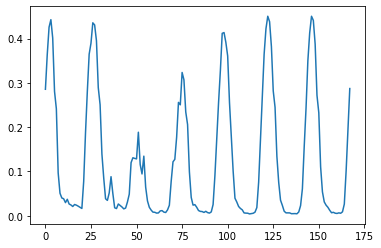

In [8]:
plt.plot(epot_hourly[:24*7])
plt.show()

## WCM

Frequency: multi-daily

Inputs:
- $\sigma^0$, $\theta$ (hourly, rounded to nearest midnight)
- vegetation descriptors (NDVI, LAI, CR) (average, daily)

In [9]:
#----------------------------------------------------------------------------
# Sigma0 values

# Freq: D
# Daily values of backscattering from 2014 to 2022 (complete S1 series)
# Data extracted:
# - sigma0 values, VV and VH
# - angle of incidence of reference orbit (nearest to 40°)

sigma_df = pd.read_csv('..\Data\\budrio-half.csv', delimiter='\t');
sigma_df['Datetime'] = sigma_df.Date.apply(lambda x : pd.to_datetime(x))
angle_mean_95 = sigma_df.loc[sigma_df.Orb==95]['Angle[°]'].mean()
sigma_df['Angle[°]'] = sigma_df['Angle[°]'].apply(lambda x : angle_mean_95)
sigma_df.Date = sigma_df.Date.apply(lambda x : pd.to_datetime(x).round(freq='D'))
sigma_df = sigma_df.set_index('Date')
if verbose: sigma_df.info()

In [10]:
#----------------------------------------------------------------------------
# NDVI values

# Freq: D
# Daily values of NDVI from 2017-4-24 to 2023-1-13 (complete S2 series)
# Data extracted:
# - NDVI (daily, interpolated)

ndvi_df = pd.read_csv('..\Data\\budrio-half_NDVI_discrete.csv', delimiter='\t');
ndvi_df.Date = ndvi_df.Date.apply(lambda x : pd.to_datetime(x))
ndvi_df = ndvi_df.set_index('Date')
ndvi_df = ndvi_df.resample('H').asfreq().interpolate(method='linear')
if verbose: ndvi_df.info()

# Input data

In [11]:
# Input SWB
# Frequency: daily
# Data:
# - rain (sum, end of day) from platinum_resampled
# - eto (daily) from eto_df

if freq=='d':
    input_swb = pd.merge(right=eto_df, left=platinum_resampled.sum(),
                     right_on='Date', left_on='Datetime', right_index=True)\
                    .drop(['SWC[m3/m3]','Temperatura[°C]'], axis=1)
    input_swb['SWC[m3/m3]'] = platinum_resampled.mean()['SWC[m3/m3]']
    if verbose: input_swb.info()

# Input SWB
# Frequency: hourly
# Data:
# - rain (hourly) from platinum_df, linear interpolation
# - irrigation (hourly) from platinum_df
# - eto (daily) from eto_df, up-resampled hourly with linear interpolation

elif freq=='h':
    # eto_df_h = eto_df.resample('H').asfreq().interpolate(method='linear')
    eto_df_h = pd.DataFrame(timeseries(t, epot_hourly)).rename(columns={0:'Datetime', 1:'EPOT'})
    eto_df_h.set_index('Datetime')
    input_swb = pd.merge(right=eto_df_h, left=platinum_df,
                         on='Datetime',)\
                        .drop(['Temperatura[°C]'], axis=1)
    input_swb.set_index('Datetime', inplace=True)
    input_swb['Pioggia[mm]'].interpolate(method='linear',inplace=True)
    input_swb['EPOT'].interpolate(method='linear',inplace=True)
    if verbose: input_swb.info()

In [12]:
# Input WCM
# Frequency: daily
# Data:
# - sigma0 (multi-daily, rounded at nearest midnight)
# - NDVI (daily, interpolated)
# Merging is performed without any time offset, considering that the change
# in ndvi values anywhere is very small from one day to another 

input_wcm_sat = pd.merge(right=sigma_df, left=ndvi_df, on='Date', how='right')
input_wcm_sat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1150 entries, 2014-10-12 to 2022-11-28
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   NDVI         916 non-null    float64       
 1   Geometry_x   0 non-null      object        
 2   Angle[°]     1150 non-null   float64       
 3   Geometry_y   1150 non-null   object        
 4   Orb          1150 non-null   int64         
 5   Pass         1150 non-null   object        
 6   VV_norm[dB]  1150 non-null   float64       
 7   VH_norm[dB]  1150 non-null   float64       
 8   CR           1150 non-null   float64       
 9   Datetime     1150 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 98.8+ KB


In [13]:
input_wcm = pd.merge(right=input_wcm_sat, left=platinum_df, on='Datetime',
                     how='inner')\
            .drop(['Pioggia[mm]','Irrigazione[mm]','Temperatura[°C]',
                   'Geometry_x'], axis=1)\
            .rename(columns={'SWC[m3/m3]':'SWC_h', 'Geometry_y':'Geometry',
                             'VV_norm[dB]':'VV', 'VH_norm[dB]':'VH', 'Angle[°]':'Angle'})

#----------------------------------------------------------------------------
# Convenience method for printing labels of columns that are interpolated
# only on the basis of their length being less than the length of the df,
# and not taking into consideration if they are being interpolated or extr

# print('The following columns will be interpolated: '
#       +f'{[x for x in input_wcm if len(input_wcm[x].dropna())<len(input_wcm)]}\n')
# if input('Proceed? [y/n]')!='y':
#      raise NameError('Stop and stare! I think I\'m going but I don\'t know where!')
#----------------------------------------------------------------------------

print(
    '\nNDVI values are limited below at the 24 of april 2017, so they are'+
    'backward propagated for 30 days in order to cover the whole Budrio period.'+
    ' There is a gap in SWC values: this gap is not interpolated but is used to'+
    'eliminate those days with nan SM values from the days of passage of the'+
    'satellite.\n'
)
input_wcm.NDVI.interpolate(method='bfill',
                           limit_direction='backward',
                           limit=30,
                           # limit_area='inside', # THIS WORKS VERY BADLY IN EVERY WAY
                           inplace=True)
if freq=='d': input_wcm.index = input_wcm.Datetime.round('D')
elif freq=='h': input_wcm.index = input_wcm.Datetime
input_wcm.dropna(inplace=True)
if verbose: input_wcm.info()


NDVI values are limited below at the 24 of april 2017, so they arebackward propagated for 30 days in order to cover the whole Budrio period. There is a gap in SWC values: this gap is not interpolated but is used toeliminate those days with nan SM values from the days of passage of thesatellite.



In [14]:
# List of 2017 and 2020 dates

# Complete hours in 2017, 2020
t = [x for x in input_swb.index if x.year==year]
     
# Hours of passage of satellite, intersect with complete days
set1 = {x for x in input_swb.index}; set2 = {x for x in input_wcm.index};
intersect = np.sort(np.array([*set1.intersection(set2)]))
t_sat = [x for x in intersect if x.year==year]

In [15]:
P       = input_swb.loc[t]['Pioggia[mm]'].values # [mm]
IRR_obs = input_swb.loc[t]['Irrigazione[mm]'].values # [mm]
EPOT    = input_swb.loc[t]['EPOT'].values # [mm/day]
WW_obs  = input_swb.loc[t]['SWC[m3/m3]'].values # daily mean or hourly, with gaps
WW_sat  = input_wcm.loc[t_sat]['SWC_h'].values # punctual at hour (observed) [m3/m3]
veg     = input_wcm.loc[t_sat]['NDVI'].values # [-]
angle   = input_wcm.loc[t_sat]['Angle'].values # [°]
VV      = input_wcm.loc[t_sat]['VV'].values # [dB]
VH      = input_wcm.loc[t_sat]['VH'].values # [dB]
CR      = input_wcm.loc[t_sat]['CR'].values # [-]
Kc_array= Kc_curve(year, t)

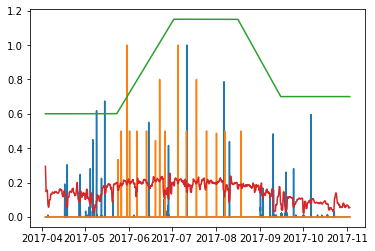

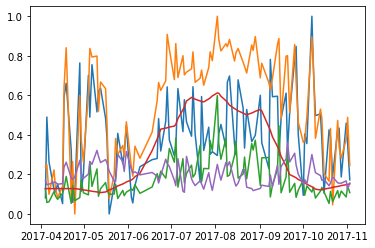

In [16]:
for x in [P,IRR_obs]: plt.plot(t, norm_simple(x));
plt.plot(t, Kc_array)
plt.plot(t, savgol_filter(EPOT, window_length=24, polyorder=1, mode='interp'))
plt.show()
for x in [norm_simple(VV),norm_simple(VH),CR,veg,WW_sat]: plt.plot(t_sat,x)
plt.show()

# Calibration SWB+WCM

In [18]:
if opt_calib=='1':
    def pso_calib_irri(PAR):
        """Ausiliary function for PSO optimization"""
        global inputs
        global user_in
        n_particles = PAR.shape[0]
        err = np.zeros(n_particles)
        for i in range(n_particles):
            WW,IRR,sig0,KGE = IRR_WCM(PAR[i], inputs, user_in)
            err[i] = 1 - KGE
        return err

elif opt_calib=='2':
    def pso_calib_irri(PAR):
        """Ausiliary function for PSO optimization"""
        global inputs
        global user_in
        n_particles = PAR.shape[0]
        err = np.zeros(n_particles)
        for i in range(n_particles):
            WW,IRR,sig0,KGE = IRR_WCM(PAR[i], inputs, user_in)
            KGE_SM =he.evaluator(he.kge, WW, WW_obs)[0,:][0]
            err[i] = 2 - KGE - KGE_SM
        return err

In [19]:
import os
import re
import time
import math
import numpy as np
import pandas as pd
import datetime as dtt
import hydroeval as he


def lin_db(x):
    """linear to dB"""
    return 10*np.log10(x)


def db_lin(x):
    """dB to linear"""
    return 10**(x/10)


def timeseries(dates, data):
    """Returns a matrix (list of type(dates,data)) in the format [dates,data]"""
    
    if len(dates)==len(data):
        return [[dates[i],data[i]] for i in range(len(dates))]
    else: raise ValueError(
        f'dates and data must have same first dimension, but have shapes {np.shape(dates)} and {np.shape(data)}')
    

#############################################################################
# Soil Water Balance + Water Cloud model
#############################################################################

def IRR_WCM(PAR, inputs, user_in):
    """Irrigation model and WCM integration.
    
    Based on minimization of KGE between observed and simulated
    $\sigma^0$ values via PSO (pyswarm) optimization.
    The soil water balance model (IRR) produces an estimate of the soil water
    content WW [%] that is used to simulate $\sigma^0$ by a water cloud
    model (WCM).
    
    Inputs
    ----------
    - PAR: initial guess values for parameters to calibrate
        PAR = [A, B, C, D, W_0, W_max, S_fc, S_w, rho_st, Kc]
    - inputs: input quantities for calibration,
        [d, d_sat, P, IRR_obs, EPOT, WWobs, LAI, t_deg, obs]
    - user_in: user-defined options
        irri = user_in: if user_in=True, irrigation is estimated
        and not taken as an input, else the input observed irrigation
        is used in the soil water balance
    
    Return
    -------
    KGE from hydroeval between sigma0 observed and simulated.
    
    """

    # User input
    irri, units = user_in
    
    # Unpack inputs
    A, B, C, D, W_max, WW_fc, WW_w, Kc0 = PAR
    t, t_sat, P, IRR_obs, EPOT, Kc, WW_obs, WW_sat, veg, angle, sig0_obs, freq = inputs
    
    angle_m = np.mean(angle)
    Ks      = 0. # water stress coefficient
    rho     = 0. # depletion fraction
    WW      = np.array([.0]*len(t)) # water content [m3/m3]
    WW[0]   = WW_obs[0] # initial value of sm [m3/m3]
    depth   = 0. # dynamic depth [mm]
    sig0    = np.array([.0]*len(t_sat)) # backscattering
    global rho_st
    
    COST   = .0   # additional cost to KGE
    LAMBDA = 1000 # Lagrange multiplier
    
    for i in [i+1 for i in range(len(t)-1)]:
        
        # Compute DoI of W[i-1]
        depth = doi(freq=freq,
                    sand=45, clay=15,
                    water=WW[i-1],
                    angle=angle_m)\
                    *1000\
                    *W_max\
            # *1000 is to account for going from [m] to [mm]
        
        # Build Ks curve    
        # Compute crop coeff and depletion fraction
        rho=rho_st+0.04*(5-Kc[i]*Kc0*EPOT[i]*24)
        if   rho<0.1: COST += (rho-0.1)**2 # regularization
        elif rho>0.8: COST += (rho-0.8)**2 # regularization
        
        if WW[i-1]>=(1-rho)*WW_fc:
            Ks=1
        elif (WW[i-1]>WW_w)and(WW[i-1]<(1-rho)*WW_fc):
            Ks=float(float(WW[i-1]-WW_w)/float((1-rho)*(WW_fc-WW_w)))
        else: Ks=0
        
        # Water balance [mm]
        WW[i]=WW[i-1]+(P[i]+IRR_obs[i]-EPOT[i]*Kc[i]*Kc0*Ks)/(depth)
        
        # Computation of deep percolation (water above field capacity)
        if WW[i]>WW_fc: WW[i]=WW_fc
            
    WWsat = np.array([ x[1] for x in timeseries(t,WW) if x[0] in t_sat ])
    
    # Water Cloud Model
    sig0,KGE = WCM([A,B,C,D], [WWsat,veg,angle,sig0_obs], units=units)
    
    KGE += -LAMBDA*COST
    
    return [WW,IRR_obs,sig0,KGE]


#############################################################################
# Water Cloud Model #############################################################################

def WCM(PAR, data_in, units='lin'):
    """Water Cloud Model.
    
    This function simulates backscattering with WCM and returns
    the KGE index to perform its minimization for calibration
    of parameters A,B,C,D.
    WCM is parametrized with a single vegetation descriptor (nominated
    LAI, but can be anything).
    Fitting can be performed in linear or dB scale.
    The model is written in one line in both units: this makes the calibration slightly slower, but provides more stability in the parameters' distributions.
    
    
    Inputs
    ------
    - PAR: list
        List of initial guesses for the parameters to calibrate.
    - data_in: list
        List of inputs of observables, that must be in the form:
        [SM,LAI,t_deg,obs], being SM = soil moisture,
        LAI = Leaf Area Index, t_deg = angle of observation,
        obs = observed total sigma0
    - units: str, default 'linear'
        choose to calibrate the model's parameters in 'linear' or 'db' scale
        
    Return
    ------
    KGE between simulated and observed backscattering.
    
    """

    A,B,C,D = PAR # parameters to fit
    WWsat,veg,angle,obs = data_in # input data
    
    theta  = angle*np.pi/180. # angle of incidence
    
    if units=='lin':
        sig0 = lin_db((np.exp((-2*B*veg)/np.cos(theta)))*(db_lin(C+D*WWsat))\
                      +A*veg*np.cos(theta)\
                      *(1-(np.exp((-2*B*veg)/np.cos(theta)))))
    elif units=='db':
        sig0 = (np.exp((-2*B*veg)/np.cos(theta)))*(C+D*WWsat)\
        +(A*veg*np.cos(theta)\
          *(1-(np.exp((-2*B*veg)/np.cos(theta)))))
    else: raise NameError('Please choose one of the options: lin/db')
        
    OUT=he.evaluator(he.kge, sig0, obs) # OUT is kge, r, alpha, beta
    KGE=OUT[0,:][0]

    return [sig0,KGE]

#############################################################################
# Model with all parameters to input by default
#############################################################################

def IRR_WCM_allpar(PAR, inputs, user_in):
    """Irrigation model and WCM integration.
    
    Based on minimization of KGE between observed and simulated
    $\sigma^0$ values via PSO (pyswarm) optimization.
    The soil water balance model (IRR) produces an estimate of the soil water
    content WW [%] that is used to simulate $\sigma^0$ by a water cloud
    model (WCM).
    
    Inputs
    ----------
    - PAR: initial guess values for parameters to calibrate
        PAR = [A, B, C, D, W_0, W_max, S_fc, S_w, rho_st, Kc]
    - inputs: input quantities for calibration,
        [d, d_sat, P, IRR_obs, EPOT, WWobs, LAI, t_deg, obs]
    - user_in: user-defined options
        irri = user_in: if user_in=True, irrigation is estimated
        and not taken as an input, else the input observed irrigation
        is used in the soil water balance
    
    Return
    -------
    KGE from hydroeval between sigma0 observed and simulated.
    
    """

    # User input
    irri, units = user_in
    
    # Unpack inputs
    A, B, C, D, W_max, WW_fc, WW_w, rho_st, Kc0 = PAR
    d, d_sat, P, IRR_obs, EPOT, W_d, W_h, veg, angle, sig0_obs = inputs
    
    # Fixed parameters
    W_0    = W_d[0]
    
    theta  = angle*np.pi/180. # angle of incidence
    W_fc   = WW_fc*W_max # field capacity [mm]
    W_w    = WW_w*W_max # wilting point [mm]
    Ks     = [0]*len(d) # daily, water stress coefficient
    rho    = [0]*len(d) # daily, depletion fraction
    PS     = [0]*len(d) # daily, deep percolation
    W      = [0]*len(d) # daily, water content [mm]
    W[0]   = W_0*W_max # initial value of sm [mm]
    if irri==True: IRR = [0]*len(d) # daily, water content
    else: IRR = IRR_obs
    
    for t in [i+1 for i in range(len(d)-1)]:
        
        DOY=d[t].dayofyear
        
        # Build Kc curve
        # Ref. FAO56, Tables 11, 12
        START  = 134
        Kc_ini = 0.6*Kc0
        Kc_mid = 1.15*Kc0
        Kc_late= 0.7*Kc0

        INI =[x for x in range(START, START+30)] # initial phenological phase
        DEV =[x for x in range(START+30, START+30+40)] # development phase
        m1  =(Kc_mid-Kc_ini)/40 # daily Kc growth in DEV phase 
        MID =[x for x in range(START+30+40, START+30+40+45)] # mid phase
        LATE=[x for x in range(START+30+40+45, START+30+40+45+30)] # late stage
        m2  =(Kc_late-Kc_mid)/30 # daily Kc growth in senescence
        
        if DOY in INI: Kc=Kc_ini
        elif DOY in DEV: Kc=Kc_ini+m1*(DOY-DEV[0])
        elif DOY in MID: Kc=Kc_mid
        elif DOY in LATE: Kc=Kc_mid+m2*(DOY-LATE[0])
        elif DOY>LATE[-1]: Kc=Kc_late
        else: Kc=Kc_ini
        
        # Build Ks curve
        rho[t]=rho_st+0.04*(5-Kc*EPOT[t])
        if W[t-1]>=(1-rho[t])*W_fc:
            Ks[t]=1
        elif (W[t-1]>W_w)and(W[t-1]<(1-rho[t])*W_fc):
            Ks[t]=float(W[t-1]-W_w)/((1-rho[t])*(W_fc-W_w))
        else: Ks[t]=0
        
        # Irrigation estimate (for summer season only)
        # Irrigation is estimated as the amount of water needed from the day
        # before to take water content up to field capacity
        if irri==True:
            if np.logical_and(DOY>START,DOY<START+100): # summer season
                if W[t-1]<=(1-rho[t])*W_fc: IRR[t]=W_fc-W[t-1]
        
        # Water balance [mm]
        W[t]=W[t-1]+P[t]+IRR[t]-EPOT[t]*Kc*Ks[t]
        
        # Computation of deep percolation (water above field capacity)
        if W[t]>W_fc:
            PS[t]=W[t]-W_fc
            W[t]=W_fc
            
    WW=np.array(W)/W_max
    WWsat = np.array([ x[1] for x in timeseries(t,WW) if x[0] in t_sat ])
    
    # Water Cloud Model    
    sig0,KGE = WCM([A,B,C,D], [WWsat,veg,angle,sig0_obs], units=units)

    return [WW,IRR,sig0,KGE]

#----------------------------------------------------------------------------

def SM_fromWCM(PAR, data_in, units='lin'):
    """Inverted WCM for SM estimation."""

    A,B,C,D = PAR # parameters, fitted
    WWsat,veg,angle,obs = data_in # input data
    
    theta = angle*np.pi/180. # angle of observation
    T2 = np.exp((-2*B*veg)/np.cos(theta)) # attenuation
    sig0v = A*veg*np.cos(theta)*(1-T2) # sigma0_veg
    
    if units=='lin':
        sig0s_lin = (db_lin(obs)-sig0v)/T2
        SMretr = (lin_db(sig0s_lin)-C)/D
    elif units=='db':
        sig0s = (obs-sig0v)/T2
        SMretr = (sig0s-C)/D 
    
    OUT=he.evaluator(he.kge, SMretr, WWsat) # OUT is kge, r, alpha, beta
    KGE=OUT[0,:];

    return [SMretr,KGE]



#############################################################################
# Soil Water Balance
#############################################################################

def SWB(PAR_SWB, inputs, user_in):
    """Soil water balance + irrigation estimation model .
    
    The soil water balance model (IRR) produces an estimate of the soil water
    content WW [%] and irrigation requirement IRR [mm].
    Ref: Rolle, 2021
    
    Inputs
    ----------
    - PAR: initial guess values for parameters to calibrate
        PAR = [A, B, C, D, W_0, W_max, S_fc, S_w, rho_st, Kc]
    - inputs: input quantities for calibration,
        [d, d_sat, P, IRR_obs, EPOT, WWobs, LAI, t_deg, obs]
    - user_in: user-defined options
        irri = user_in: if user_in=True, irrigation is estimated
        and not taken as an input, else the input observed irrigation
        is used in the soil water balance
    
    Return
    -------
    [WW, IRR]: simulated water content and irrigation requirement 
    
    """

    # User input
    irri, units = user_in
    
    # Unpack inputs
    W_max, WW_fc, WW_w, rho_st, Kc0 = PAR_SWB
    d, P, IRR_obs, EPOT, W_d = inputs
    
    # Fixed parameters
    # global WW_fc  # = 0.32 # 0.32
    # global WW_w   # = 0.08 # 0.08
    # global rho_st # = 0.4 # /24 # 0.4
    # global Kc0    # = 1 # 0.05 # 1
    W_0 = W_d[0]
    
    W_fc   = WW_fc*W_max # field capacity [mm]
    W_w    = WW_w*W_max # wilting point [mm]
    Ks     = [0]*len(d) # daily, water stress coefficient
    rho    = [0]*len(d) # daily, depletion fraction
    PS     = [0]*len(d) # daily, deep percolation
    W      = [0]*len(d) # daily, water content [mm]
    W[0]   = W_0*W_max # initial value of sm [mm]
    if irri==True: IRR = [0]*len(d) # daily, water content
    else: IRR = IRR_obs
    
    for t in [i+1 for i in range(len(d)-1)]:
        
        DOY=d[t].dayofyear
        
        # Build Kc curve
        # Ref. FAO56, Tables 11, 12
        START  = 134 # 14 May
        Kc_ini = 0.6*Kc0
        Kc_mid = 1.15*Kc0
        Kc_late= 0.7*Kc0

        INI =[x for x in range(START, START+30)] # initial phenological phase
        DEV =[x for x in range(START+30, START+30+40)] # development phase
        m1  =(Kc_mid-Kc_ini)/40 # daily Kc growth in DEV phase 
        MID =[x for x in range(START+30+40, START+30+40+45)] # mid phase
        LATE=[x for x in range(START+30+40+45, START+30+40+45+30)] # late stage
        m2  =(Kc_late-Kc_mid)/30 # daily Kc growth in senescence
        
        if DOY in INI: Kc=Kc_ini
        elif DOY in DEV: Kc=Kc_ini+m1*(DOY-DEV[0])
        elif DOY in MID: Kc=Kc_mid
        elif DOY in LATE: Kc=Kc_mid+m2*(DOY-LATE[0])
        elif DOY>LATE[-1]: Kc=Kc_late
        else: Kc=Kc_ini
        
        # Build Ks curve
        rho[t]=rho_st+0.04*(5-Kc*EPOT[t])
        if W[t-1]>=(1-rho[t])*W_fc:
            Ks[t]=1
        elif (W[t-1]>W_w)and(W[t-1]<(1-rho[t])*W_fc):
            Ks[t]=float(W[t-1]-W_w)/((1-rho[t])*(W_fc-W_w))
        else: Ks[t]=0
        
        # Irrigation estimate (for summer season only)
        # Irrigation is estimated as the amount of water needed from the day
        # before to take water content up to field capacity
        if irri==True:
            if np.logical_and(DOY>START,DOY<START+100): # summer season
                if W[t-1]<=(1-rho[t])*W_fc: IRR[t]=W_fc-W[t-1]
        
        # Water balance [mm]
        W[t]=W[t-1]+P[t]+IRR[t]-EPOT[t]*Kc*Ks[t]
        
        # Computation of deep percolation (water above field capacity)
        if W[t]>W_fc:
            PS[t]=W[t]-W_fc
            W[t]=W_fc
            
    WW=np.array(W)/W_max

    return [WW,IRR]


#############################################################################
# Hallikainen model for doi estimation
#############################################################################

import numpy as np

# Part,Frequency(GHz),a0,a1,a2,b0,b1,b2,c0,c1,c2
coeff = {
    4: 
    {
        'real':[ 2.927,-0.012,-0.001,5.505,0.371,0.062,114.826,-0.389,-0.547],
        'img':[0.004,0.001,0.002,0.951,0.005,-0.01,16.759,0.192,0.29]
    },
    6: 
    {
        'real':[1.993,0.002,0.015,38.086,-0.176,-0.633,10.72,1.256,1.522],
        'img':[-0.123,0.002,0.003,7.502,-0.058,-0.116,2.942,0.452,0.543]
    }
}


def hallikainen(freq:int, sand:float, clay:float, water:np.array):
    """
    coeff: dict('real':[],'img':[])
    """
    global coeff
    
    coeff_r = np.array(coeff[freq]['real'])
    real = coeff_r[0]+coeff_r[1]*sand+coeff_r[2]*clay+\
    (coeff_r[3]+coeff_r[4]*sand+coeff_r[5]*clay)*water+\
    (coeff_r[6]+coeff_r[7]*sand+coeff_r[8]*clay)*(water**2)
        
    coeff_i = np.array(coeff[freq]['img'])
    img = coeff_i[0]+coeff_i[1]*sand+coeff_i[2]*clay+\
    (coeff_i[3]+coeff_i[4]*sand+coeff_i[5]*clay)*water+\
    (coeff_i[6]+coeff_i[7]*sand+coeff_i[8]*clay)*(water**2)
    
    return real, img

def doi(freq:int, sand:float, clay:float, water:np.array, angle:float):
    """
    freq [GHz]
    angle [°]
    
    return depth [m]
    """
    c = 299792458 # m/s
    theta  = angle*np.pi/180. # angle [rad]
    
    real = hallikainen(freq, sand=sand, clay=clay, water=water)[0]
    img = hallikainen(freq, sand=sand, clay=clay, water=water)[1]
    
    depth =  c/(2*np.pi*freq*1e9)*(np.sqrt(real)/img)*np.cos(theta)
    
    return depth


#############################################################################
# Snippets and old versions of the code
#############################################################################

    # Water Cloud Model
    # Multi-line, double units version
    #---------------------------------
    # sig0s_dB = C+D*WWsat # sigma0_soil [dB]
    # T2 = np.exp((-2*B*veg)/np.cos(angle)) # attenuation
    # sig0v = A*veg*np.cos(angle)*(1-T2) # sigma0_veg [units]
    # 
    # if units=='lin':
    #     sig0s = db_lin(sig0s_dB) # sigma0_soil [lin]
    #     sig0_lin = T2*sig0s+sig0v # sigma0_tot [lin]
    #     sig0=lin_db(sig0_lin) # sigma0_tot [dB]
    # elif units=='db':
    #     sig0 = T2*sig0s_dB+sig0v # sigma0_tot [db]
    # else: raise NameError('Please choose one of the options: lin/db')
    
    
    # Old method for WW_sat cut on d_sat dates
    #-----------------------------------------
    # WWsat = pd.DataFrame(timeseries(d,WW))\
    #           .set_index(0).loc[d_sat][1].values

In [20]:
# Calibration SWB+WCM

print('Starting calibration...\n'+
      '#-------------------------------------------------------------\n')

A=0.3; B=1.5; C=-15; D=30 # guess params for WCM
W_max=    100;   # [mm] water content, maximum (not normalized)
WW_fc=    0.32; # [m3/m3] water content at field capacity
WW_w=     0.09; # [m3/m3] water content at wilting point
rho_st=   0.4;  # [-] crop specific depletion fraction
Kc0=      1/2;  # [-] crop specific coefficient
# if freq=='h': rho_st/=24; Kc0/=1
freq = 6 # frequency for DoI computation

# PAR default
# PAR_str = ['A', 'B', 'C', 'D', 'W_max', 'WW_fc', 'WW_w', 'rho_st', 'Kc0']
PAR_str = ['A', 'B', 'C', 'D', 'W_max', 'WW_fc', 'WW_w', 'rho_st', 'Kc0']
if units=='db': PAR_str = [el + '_db' for el in PAR_str]

# PAR to calibrate
# A, B, C, D, W_max, WW_fc, WW_w, rho_st, Kc0
PAR     = [A, B, C, D, W_max, WW_fc, WW_w, Kc0]
PARn_str= ['A', 'B', 'C', 'D', 'W_max', 'WW_fc', 'WW_w', 'Kc0']
inputs  = [t, t_sat, P, IRR_obs, EPOT, Kc_array, WW_obs, WW_sat, veg, angle, VV, freq]
user_in = [irri, units]

if units=='lin':
    bounds = (
        np.array([0, 0, -30,  10, 1, 0.29, 0.06, 0]), # low
        np.array([1, 3,  -5, 100, 2, 0.35, 0.12, 1]), # up
    )
elif units=='db':
    bounds = (
        np.array([ -20, 0.1, -30, 10,   1, 0.3, 0.01,]), # low
        np.array([ -10, 3,    -5,100, 150, 0.5, 0.2, ]),  # up
    )
#     bounds = (
#         np.array([0.01,0.1,-30, 10,   1, 0.3, 0.01,0.01, 0.001]), # low
#         np.array([1,   3,   -5,100, 150, 0.5, 0.2, 0.8,  1]),  # up
#     )
else: raise NameError(f'Scale can only be lin or db but {scale} was provided.')

#-----------------------------------------------------------------------------
from pyswarms.backend.handlers import OptionsHandler

# params = []
start = time.time()
for i in range(int(nrun)):
    
    print('Run number ', i+1)
    if (optim=='global')or(optim==''):
        optim='global'
        # options = {'c1': 0.5, 'c2': 0.9, 'w': 0.6}
        options = {'c1': 2.05, 'c2': 2.05, 'w': 0.6}
        oh_strategy = {"w":'exp_decay', 'c1':'lin_variation', 'c2':'lin_variation'}
        optimizer = ps.single.GlobalBestPSO(n_particles=int(n_particles),
                                            dimensions=len(PAR),
                                            options=options,
                                            bounds=bounds,
                                            oh_strategy=oh_strategy,
                                           )
    elif optim=='local':
        options = {'c1': 0.4, 'c2': 0.4, 'w': 0.8, 'k':int(0.1*n_particles), 'p':norma }
        optimizer = ps.single.LocalBestPSO(n_particles=n_particles,
                                           dimensions=len(PAR),
                                           options=options,
                                           bounds=bounds,
                                           oh_strategy=oh_strategy,
                                          )
    else: raise NameError('Please provide an accepted option.')
    cost, PARn = optimizer.optimize(pso_calib_irri, n_step, verbose=verbose_calib)#, **PAR)
    params.append(PARn)
    end = time.time()
    if i==0:
        time_sec = round(end-start, 2)
        time_min =  round((end-start)/60, 2)
        print(time_min, ' min for last run,', time_min*nrun , ' min estimated')
    print('Time left: ', round((start+time_sec*nrun-end)/60,2), 'min')

timestr = time.strftime("%y%m%d-%H%M%S"); print('Timestring: ', timestr)

Starting calibration...
#-------------------------------------------------------------

Run number  1
6.41  min for last run, 128.2  min estimated
Time left:  121.88 min
Run number  2
Time left:  115.49 min
Run number  3
Time left:  109.12 min
Run number  4
Time left:  102.74 min
Run number  5
Time left:  96.36 min
Run number  6
Time left:  89.99 min
Run number  7
Time left:  83.59 min
Run number  8
Time left:  77.21 min
Run number  9
Time left:  70.84 min
Run number  10
Time left:  64.49 min
Run number  11
Time left:  58.11 min
Run number  12
Time left:  51.74 min
Run number  13
Time left:  45.4 min
Run number  14
Time left:  39.17 min
Run number  15
Time left:  32.95 min
Run number  16
Time left:  26.76 min
Run number  17
Time left:  20.54 min
Run number  18
Time left:  14.34 min
Run number  19
Time left:  8.12 min
Run number  20
Time left:  1.89 min
Timestring:  230226-212600


In [21]:
print('Timing: ', round((end-start)/60/nrun, 2), ' min for 1 run,', round((end-start)/60, 2), 'min total')

Timing:  6.32  min for 1 run, 126.4 min total


# Parameters' study

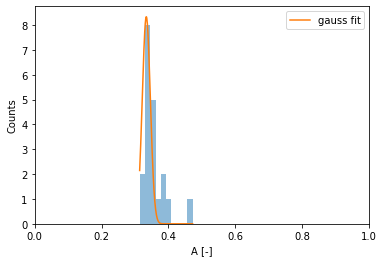

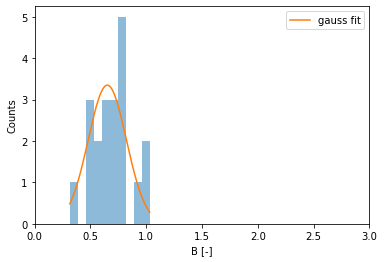

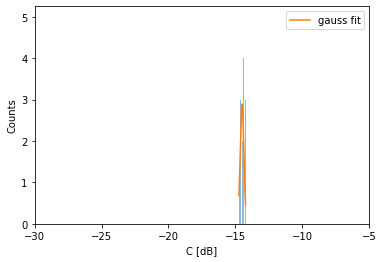

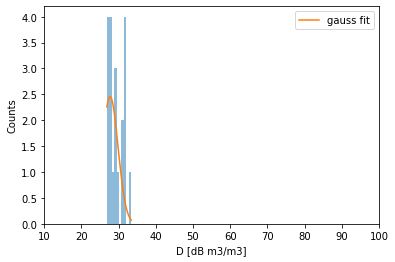

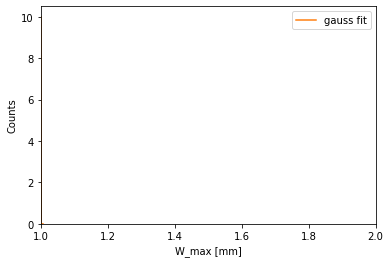

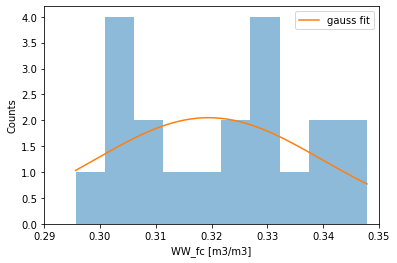

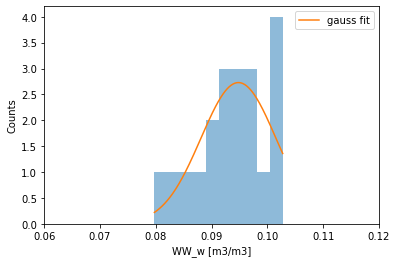

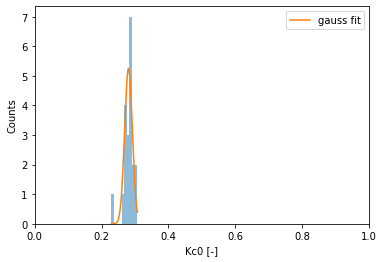

{'A': ['[-]', 'cal', [0.0, 1.0], 0.334, 0.012, array([0.34632987, 0.36051336, 0.31384508, 0.33006773, 0.37468524,
       0.47206198, 0.3536567 , 0.33389168, 0.33268099, 0.35104581,
       0.39405252, 0.34178412, 0.32253164, 0.34142137, 0.35581859,
       0.33243064, 0.38340514, 0.33877237, 0.38485251, 0.33639564])], 'B': ['[-]', 'cal', [0.0, 3.0], 0.652, 0.171, array([0.69208396, 0.60018342, 1.03227709, 1.01209561, 0.55296088,
       0.31549865, 0.64657394, 0.78691146, 0.81210746, 0.65783101,
       0.52355887, 0.73795901, 0.90066107, 0.72487773, 0.6252476 ,
       0.77518126, 0.50652838, 0.77519603, 0.51960488, 0.7530754 ])], 'C': ['[dB]', 'cal', [-30.0, -5.0], -14.507, 0.136, array([-14.5023124 , -14.66276254, -14.62583805, -14.24518467,
       -14.52406366, -14.73756211, -14.40278977, -14.25815891,
       -14.50009957, -14.59508725, -14.3895857 , -14.42214456,
       -14.29220439, -14.63463611, -14.42848177, -14.53177111,
       -14.48978924, -14.43030598, -14.4825903 , -14.50083054

In [29]:
def parameters_analysis(params, PAR, PARn_str, bounds, timestr, automate, nbins=10):
    
    matrix = np.array(
        [
            np.array(
                [ params[i][j] for i in range(len(params)) ])
            for j in range(len(PAR))
        ]
    )
    
    PAR_dict = {
        'A':      ['[-]',        round(A, 2) ],
        'B':      ['[-]',        round(B, 2) ],
        'C':      ['[dB]',       round(C, 2) ],
        'D':      ['[dB m3/m3]', round(D, 2) ],
        'W_max':  ['[mm]',       round(W_max, 2) ],
        'WW_fc':  ['[m3/m3]',    round(WW_fc, 2) ],
        'WW_w':   ['[m3/m3]',    round(WW_w, 2) ],
        'rho_st': ['[mm/h]',     round(rho_st, 2) ],
        'Kc0' :   ['[-]',        round(Kc0, 2)],
    }

    PARn = []
    PARn_dev = []
    rowLabels = []
    
    if automate: opt_save=True
    else: opt_save = True if input('Save histograms of params? [y/n]')=='y' else False
    
    for label in PAR_dict:
        if label in PARn_str:
            i = PARn_str.index(label)
            
            if len(params)==1:
                PARn=[x[0] for x in matrix]
                PARn_dev=[0 for x in matrix]
            else:
                hist_kwargs={'alpha':.5, } # 'label':f'param {label}'}
                fitline_kwargs={'linestyle':'-', 'label':f'gauss fit'}
                data = matrix[i]
                nbins = nbins # if len(params)<100 else int(np.sqrt(len(params))-4)
                plt.xlim(bounds[0][i], bounds[1][i]);
                counts, bins, pads, popt, pcov = hist_gauss_fit(
                    data, nbins=nbins, hist_kwargs=hist_kwargs, fitline_kwargs=fitline_kwargs,
                    title=f'{label} {PAR_dict[label][0]}', density=False,
                    opt_save=opt_save, dir_name='Plot\\', opt_name=f'{timestr}_hist_{label}',
                    func=gauss)
                PARn.append(popt[1])
                PARn_dev.append(popt[2])
                plt.show()
            
            PAR_dict[label].pop(1)
            PAR_dict[label].append('cal');
            PAR_dict[label].append([round(bounds[0][i],2), round(bounds[1][i],2)]);
            PAR_dict[label].append(np.round(PARn[i], 3));
            PAR_dict[label].append(np.round(PARn_dev[i], 3));
            PAR_dict[label].append(matrix[i]);            
            
            if not 'Cal/fix' in rowLabels: rowLabels.append('Cal/fix')
            if not 'Bounds' in rowLabels: rowLabels.append('Bounds')
            if not 'Mean' in rowLabels: rowLabels.append('Mean')
            if not 'Dev' in rowLabels: rowLabels.append('Dev')
            
        else:
            PAR_dict[label].append('fix')
            PAR_dict[label].append(['/', '/'])
            PAR_dict[label].append(PAR_dict[label][1])
            PAR_dict[label].append('/')
            PAR_dict[label].pop(1)
    
    print(PAR_dict, '\n', rowLabels)
    return PAR_dict, rowLabels
            
PAR_dict, rowLabels = parameters_analysis(params, PAR, PARn_str, bounds, timestr, automate, nbins=10,)

# Model output - plots sim VS obs for SM, sigma0

In [24]:
# Model validation and output

if not automate:
    if input('Do you want to plot with user-defined parameters\' values ? [y/n]')=='y':
        
        timestr = time.strftime("%y%m%d-%H%M%S"); print('Timestring: ', timestr)
        
        # PAR_tot = [PAR_dict[label][3] for label in PAR_dict]
        PAR_tot = [0.329, 0.56, -15, 30, 10, 0.32, 0.10, 0.3, 0.5]
        print(PAR_tot)
        WW,IRR,sigma0,KGE = IRR_WCM(PAR_tot, inputs, user_in)
        
    else: WW,IRR,sigma0,KGE = IRR_WCM(PARn, inputs, user_in)

else: WW,IRR,sigma0,KGE = IRR_WCM(PARn, inputs, user_in)

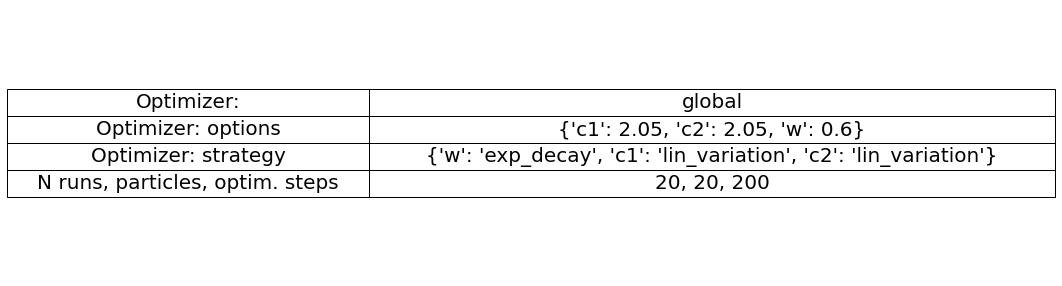

In [25]:
if automate: opt_save_table = True
else: opt_save_table = True if input('Save table with machine params? [y/n]')=='y' else False

fig, ax = plt.subplots(figsize=(14,5))
row_height=0.1; col_width=0.7

# Table with machine, inputs params
timing = 'daily' if freq=='d' else 'hourly'
calib = 'sigma0' if opt_calib=='1' else 'sigma0+sm'
cellText = [
    # ['Units', units],
    # ['Cost function', opt_cost],
    # ['Calib on', calib],
    ['Optimizer:', optim],
    ['Optimizer: options', options],
    ['Optimizer: strategy', oh_strategy],
    ['N runs, particles, optim. steps', str(nrun)+', '+str(n_particles)+', '+str(n_step)],
    # ['Time frequency', timing],
    # ['Vegetation descriptor', opt_veg],
]
table = ax.table(cellText=cellText,
                     cellLoc='center', loc='center',
                     colLabels=None, rowLabels=None)

for (row, col), cell in table.get_celld().items():
    cell.set_height(row_height)
    cell._loc = 'center'

table.auto_set_font_size(False); table.set_fontsize(20)
table.auto_set_column_width(col=[x for x in range(len(PAR_dict))])
ax.axis('tight'); ax.axis('off')

if opt_save_table: plt.savefig(f'Plot\\{timestr}_table_mach.png', dpi=100)
plt.show()

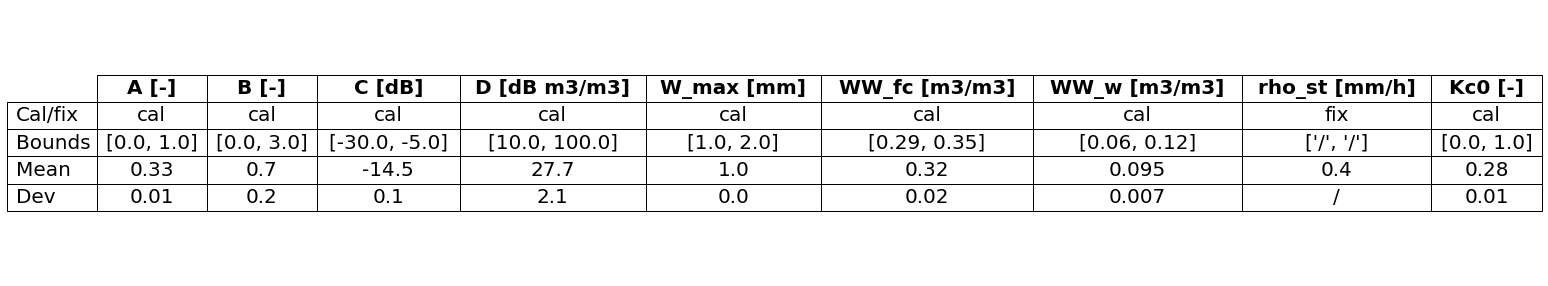

In [30]:
if automate: opt_save_table = True
else: opt_save_table = True if input('Save table with params? [y/n]')=='y' else False

fig, ax = plt.subplots(figsize=(24,5))
row_height=0.1; col_width=0.1

# Table with params

def significant_figures_str(master, slave):
    master_rounded = float("%.1g" % master)
    master_rounded_str = str(master_rounded)
    digits = master_rounded_str[::-1].find('.')
    slave_rounded_str = str(f'%.{digits}f' % slave)
    
    return [master_rounded_str, slave_rounded_str]

single_label = [label for label in PAR_dict][0]
cellText = [
    [
        significant_figures_str(PAR_dict[label][4],PAR_dict[label][i])[1] if type(PAR_dict[label][i])==np.float64
        else PAR_dict[label][i]
        for label in PAR_dict
    ] 
    for i in range(1,1+len(rowLabels))]

colLabels = [ f'{label} {PAR_dict[label][0]}' for label in PAR_dict ]
# rowLabels = [ 'Guess/fix value', 'Cal/fix', 'Bounds', 'Mean', 'St.dev.']

#---------------------------------
table = ax.table(cellText=cellText,
                  cellLoc='center', loc='center',
                  colLabels=colLabels,
                  rowLabels=rowLabels,
                )

for (row, col), cell in table.get_celld().items():
    if row == 0: # or col == 0:
        cell.set_text_props(weight='bold')
    cell.set_height(row_height)
    cell._loc = 'center'

table.auto_set_font_size(False); table.set_fontsize(20)
table.auto_set_column_width(col=[x for x in range(len(PAR_dict))])
ax.axis('tight'); ax.axis('off')

if opt_save_table: plt.savefig(f'Plot\\{timestr}_table.png')
plt.show()

In [31]:
if automate: opt_save=True
else: opt_save = True if input('Save log with parameters\' values? [y/n]')=='y' else False

if opt_save:
    for label in PAR_dict:
        try:
            with open('Plot\\'+timestr+'_params.txt', 'w') as f: 
                for key, value in PAR_dict.items(): 
                    f.write('%s:%s\n' % (key, value))
        except ValueError:
            pass

## Triple plot SM+$\sigma^0$+inputs

RMSE = 1.3928091772487277
R= 0.6950738451085892
bias = -0.02142677474255072
KGE= 0.695019213459032
RMSE = 0.0600416324074819
R (sim vs obs) = 0.7298175610914158
KGE= 0.5620007921734193


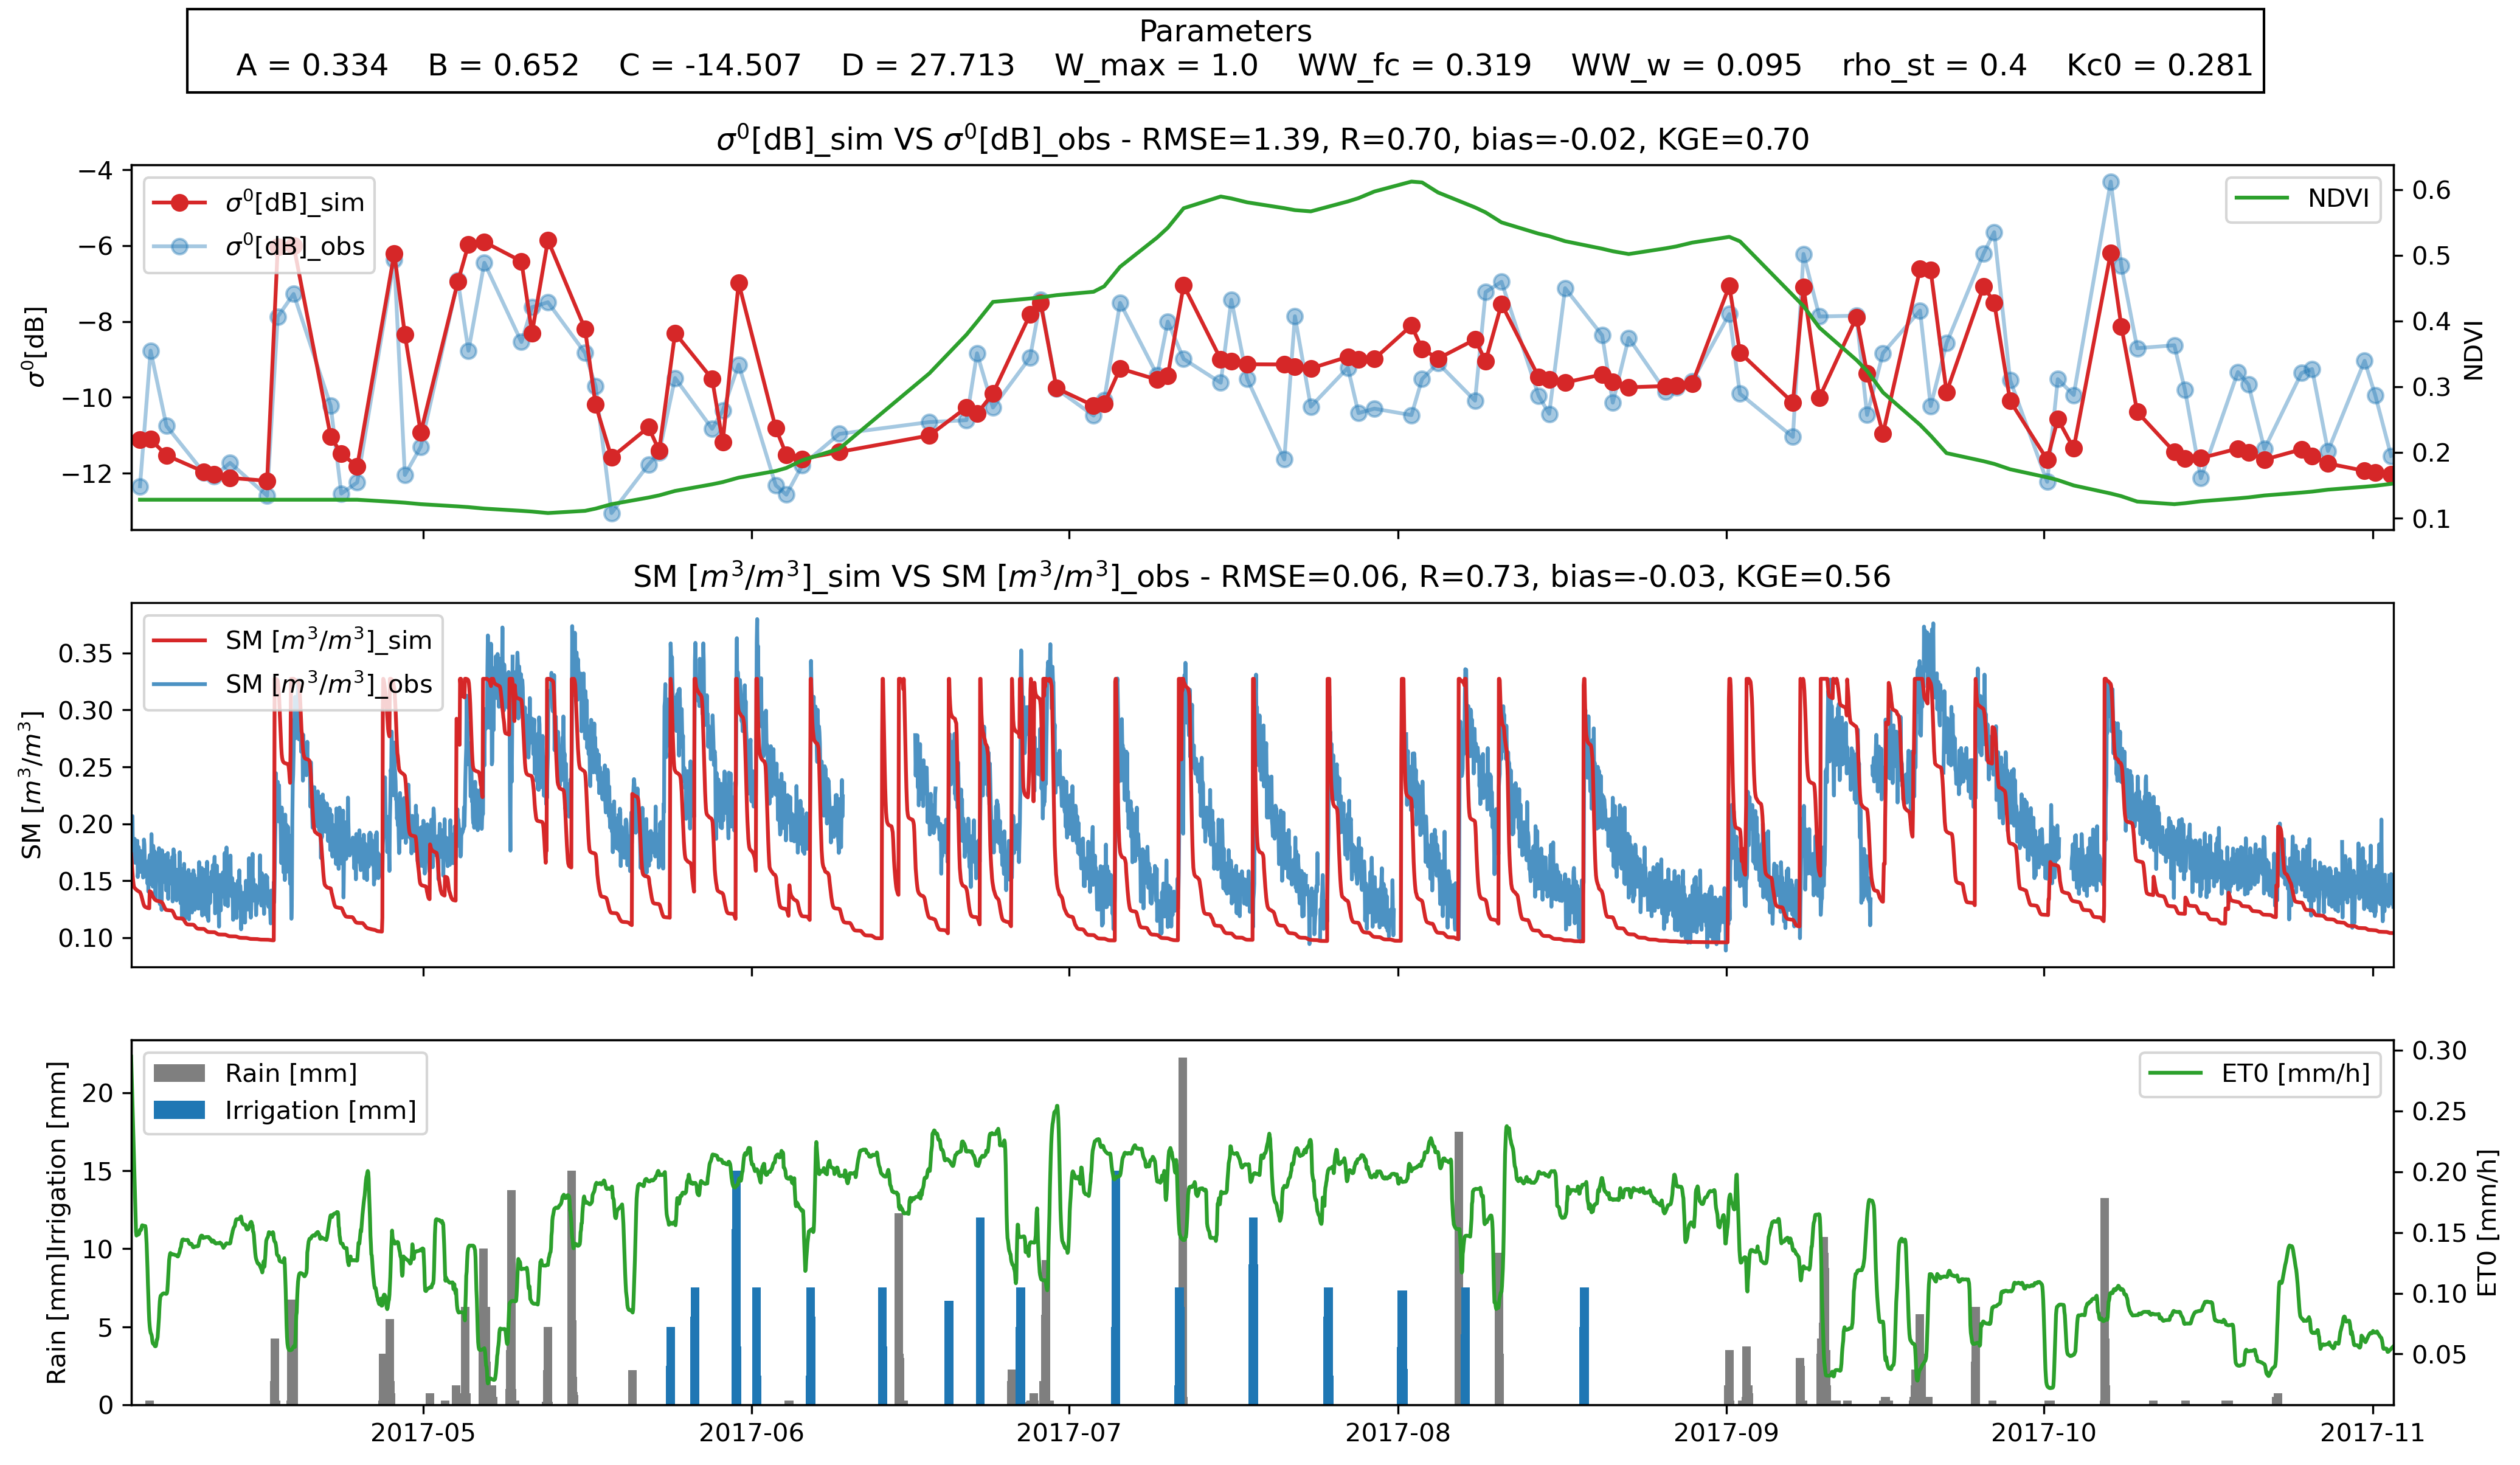

In [32]:
#-----------------------------------------------------------------------
# Triple plot

if automate: opt_save = True
else: opt_save = True if input('Save triple plot SM+s0+inputs? [y/n]')=='y' else False

fig, ax = plt.subplots(3, 1,constrained_layout=False,figsize=(16, 9), sharex=True,dpi=300,)
filename = f'triple_'+units+'_'+PAR_str_add

#----------------------------------------------------------------------------
# Box with params

PAR_text='Parameters\n'
try:
    for i in range(len(PAR_str)): PAR_text+=f'    {PAR_str[i]} = {PAR_tot[i]}'
except NameError:
    for label in PAR_dict: PAR_text+=f'    {label} = {PAR_dict[label][3]}'

fig.text(0.5, 0.95,
         PAR_text, ha='center', va='center',
         bbox={'facecolor':'white', 'edgecolor':'black'},
         transform=fig.transFigure,
         fontsize='large',
        )


def bias(obs, sim):
    """distance between obs' and sim's mean values"""
    if len(obs)==len(sim):
        return np.mean(obs-sim)
    else: raise ValueError(
        f'obs and sim must have same first dimension, but have shapes {np.shape(obs)} and {np.shape(sim)}')
    
#-----------------------------------------------------------------------
from scipy.signal import savgol_filter

plot_triple(fig, ax, times1=t_sat, data1=[VV, sigma0], data1_label=r'$\sigma^0$[dB]', 
            input1=veg, input1_label=opt_veg,
            times2=t, data2=[WW_obs, WW], data2_label=r'SM $[m^3/m^3]$',
            input2=[], input2_label='',
            times3=t, data3=
            [P,
             IRR_obs,
             savgol_filter(EPOT, window_length=24, polyorder=1, mode='interp')],
            data3_label=['Rain [mm]', 'Irrigation [mm]', 'ET0 [mm/h]'],
            user_input=[irri],
           )

name=''
if opt_save:
    optim_choice = 'glo' if (optim=='')or(optim=='global') else 'local'
    name = timestr+filename # +f'_{n_particles}_{n_step}_{optim_choice}_{norma}'
    plt.savefig('Plot\\'+name+'.png')

plt.show()

## Scatterplot

RMSE = 0.0600416324074819
R= 0.7298175610914158 R^2= 0.5326336724774224
bias= -0.03209739160282925


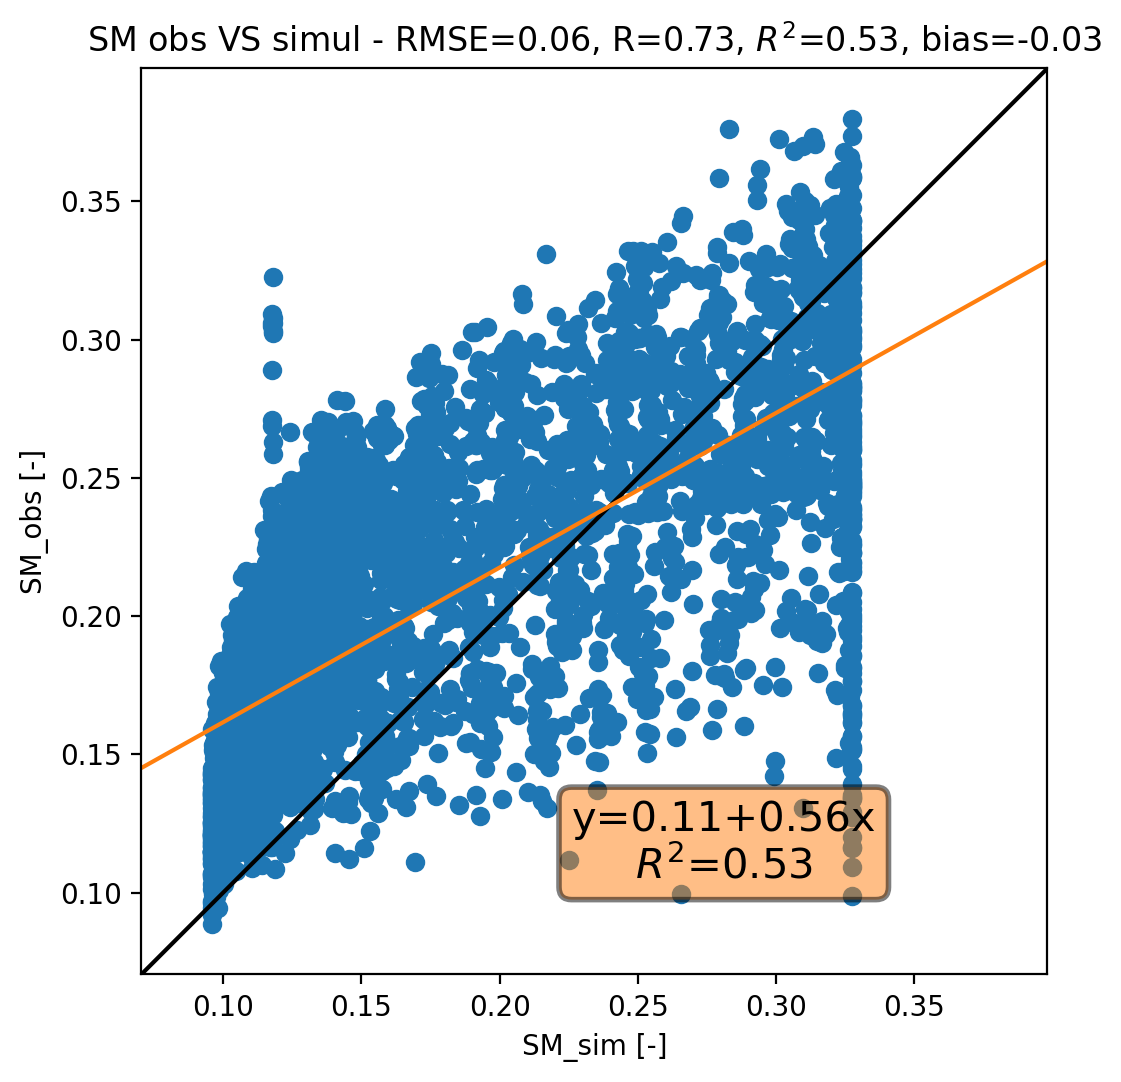

In [33]:
if automate: opt_save = True
else: opt_save = True if input('Save scatterplot of SM? [y/n]')=='y' else False

filename = f'scatter_'+'sm_'+units+PAR_str_add # 'SM'

plot_sim_vs_obs(sim=WW, obs=WW_obs, quantity='SM', um='[-]')
    
if opt_save: plt.savefig('Plot\\'+timestr+'_'+filename+'.png')

RMSE = 1.3928091772487277
R= 0.6950738451085892 R^2= 0.483127650154039
bias= -0.02142677474255072


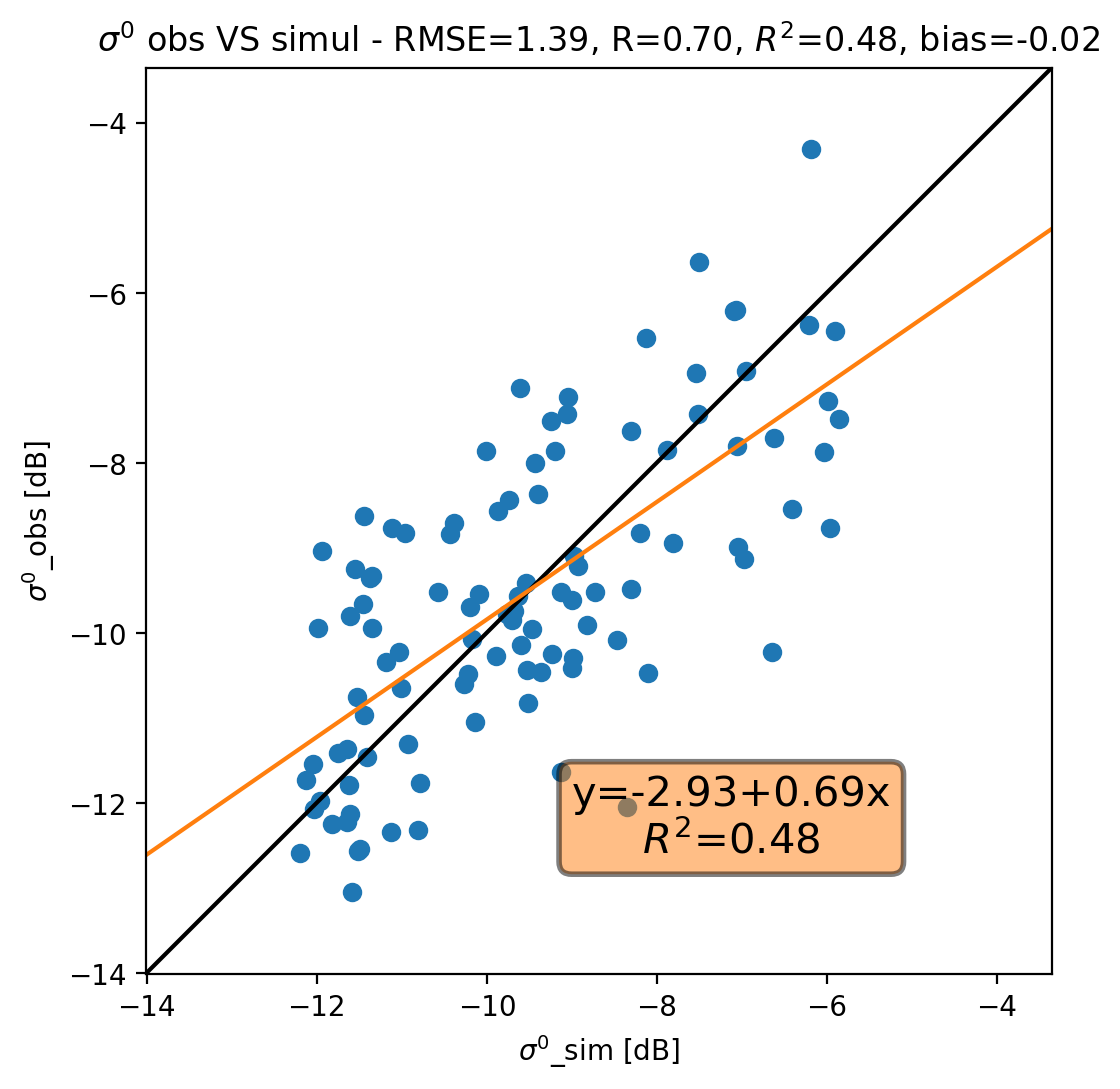

In [34]:
if automate: opt_save = True
else: opt_save = True if input('Save scatterplot of SM? [y/n]')=='y' else False

filename = f'scatter_'+'sigma0_'+units+PAR_str_add # 'sigma0'

plot_sim_vs_obs(sim=sigma0, obs=VV, quantity=r'$\sigma^0$', um='[dB]')
    
if opt_save: plt.savefig('Plot\\'+timestr+'_'+filename+'.png')

# Components

In [ ]:
PAR_tot = [0.329, 0.56, -15, 30, 10, 0.32, 0.1, 0.4, 0.3]

A, B, C, D, W_max, WW_fc, WW_w, rho_st, Kc0 = [PAR_dict[label][3] for label in PAR_dict]
t, t_sat, P, IRR_obs, EPOT, Kc, WW_obs, WW_sat, veg, angle, sig0_obs = inputs

angle_m = np.mean(angle)
Ks      = np.array([.0]*len(t)) # water stress coefficient
ET      = np.array([.0]*len(t)) # evapotranspiration
rho     = np.array([.0]*len(t)) # depletion fraction
PS      = np.array([.0]*len(t)) # deep percolation
W       = np.array([.0]*len(t)) # water content [mm]
WW      = np.array([.0]*len(t)) # water content [m3/m3]
WW[0]   = WW_obs[0] # initial value of sm [m3/m3]
depth   = np.array([.0]*len(t)) # dynamic depth [mm]
depth[0]= doi(freq=4, sand=45, clay=15, water=WW[0], angle=angle_m)*1000

W[0]    = WW_obs[0]*depth[0] # initial value of sm [mm]
sig0    = np.array([.0]*len(t_sat))

COST   = .0
LAMBDA = 1000
if irri==True: IRR = [0]*len(d) # daily, water content
else: IRR = IRR_obs


for i in [i+1 for i in range(len(t)-1)]:
    
    # Compute DoI of W[i-1]
    depth[i] = doi(freq=4,
                sand=45, clay=15,
                water=WW[i-1],
                angle=angle_m)*1000
    
    # Build Ks curve    
    # Compute crop coeff and depletion fraction
    Kci = Kc[i]*Kc0
    rho[i]=rho_st+0.04*(5-Kci*EPOT[i]*24)
    if   rho[i]<0.1: COST += (rho[i]-0.1)**2 # regularization
    elif rho[i]>0.8: COST += (rho[i]-0.8)**2 # regularization
    
    if WW[i-1]>=(1-rho[i])*WW_fc:
        Ks[i]=1
    elif (WW[i-1]>WW_w)and(WW[i-1]<(1-rho[i])*WW_fc):
        Ks[i]=float(float(WW[i-1]-WW_w)/float((1-rho[i])*(WW_fc-WW_w)))
    else: Ks[i]=0
    
    # Water balance [mm]
    # W[i]=WW[i-1]*depth[i-1]+P[i]+IRR[i]-EPOT[i]*Kci*Ks[i]
    WW[i]=WW[i-1]+(P[i]+IRR[i]-EPOT[i]*Kci*Ks[i])/(depth[i])
    
    # Computation of deep percolation (water above field capacity)
    WW_s = 0.48
    if WW[i]>WW_s:
        PS[i]=(WW[i]-WW_s)*depth[i]
        WW[i]=WW_s

In [ ]:
theta  = angle*np.pi/180. # angle of incidence (rad)

sig0s_dB = C+D*WW_sat # sigma0_soil [dB]
T2 = np.exp((-2*B*veg)/np.cos(theta)) # attenuation
sig0v = A*veg*np.cos(theta)*(1-T2) # sigma0_veg [units]

if units=='lin':
    sig0s = db_lin(sig0s_dB) # sigma0_soil [lin]
    sig0_lin = T2*sig0s+sig0v # sigma0_tot [lin]
    sig0=lin_db(sig0_lin) # sigma0_tot [dB]
elif units=='db':
    sig0 = T2*sig0s_dB+sig0v # sigma0_tot [db]
else: raise NameError('Please choose one of the options: lin/db')

In [ ]:
plt.plot(Kc*Kc0)
plt.plot(Ks)

In [ ]:
Ks

In [ ]:
plt.plot(EPOT*Kc*Kc0*Ks)

In [ ]:
Kc0

In [ ]:
plt.plot(0.01+0.04*(5-EPOT*Kc*24*Kc0)); plt.ylim(0.1, 0.8)

In [ ]:
plt.plot((1-0.01+0.04*(5-EPOT*Kc*24*Kc0))*WW_fc)
plt.plot(np.array([1]*len(t))*WW_w)
# plt.ylim(0,0.2)

In [ ]:
plt.plot(WW)
plt.plot(WW_obs)

In [ ]:
plt.scatter(WW,WW_obs)

In [ ]:
plt.plot(depth)

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(doi(freq=6, sand=45, clay=15, water=WW_obs, angle=angle_m)*1000)
ax0 = ax.twinx()
ax0.plot(WW_obs, color='tab:orange')